In [1]:
import sys  
sys.path.insert(0, "..")

In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem
from tqdm import tqdm

In [4]:
from src.models.predictor import Predictor

In [17]:
def evaluate_components(fp_list: np.ndarray) -> pd.DataFrame:
    res = []
    for n_comp in tqdm(range(2,50)):
        pca = PCA(n_components=n_comp)
        crds = pca.fit_transform(fp_list) 
        var = np.sum(pca.explained_variance_ratio_)
        res.append([n_comp,var])
    return res

In [21]:
data_path = "../data/processed/ligand_proc.csv"
data = pd.read_csv(filepath_or_buffer=data_path)
data = data[data["pchembl_value"] != 3.99]  # For testing purposes to see if the placeholders are polluting the chem space (update: makes no diff?)
smiles = list(data["smiles"])
mols = [Chem.MolFromSmiles(smi) for smi in smiles]

In [23]:
fp_list = Predictor.calc_fp(mols=mols)

In [22]:
data

,smiles,pchembl_value
0,Brc1ccc(Nc2ccc(CN3CCC4(CC3)OCCc3sccc34)cc2)cc1,5.370
1,Brc1ccc2c(NC3=NC[C@@]4(CN5CCC4CC5)O3)ncnn12,5.600
2,Brc1cccc(Nc2nc3c(N4CCCC4)ncnc3s2)c1,6.610
3,Brc1cccc2nc(C#Cc3ccccn3)ccc12,4.640
4,Brc1cnc2nc(N3CCN4CCC3CC4)oc2c1,5.640
...,...,...
12974,c1csc(-c2nc(C3CC3)nc3ccsc23)n1,7.535
12975,c1nc2nc(Nc3ccc(N4CCOCC4)cc3)nc(NC3CC4CCC3C4)c2...,4.440
12976,c1ncc(-c2cc3sc(N4CCC(N5CCCCC5)CC4)nc3cn2)cn1,5.190
12977,c1ncc(-c2ccc(OCCCN3CCCCC3)cc2)o1,5.920


In [24]:
comp_res = evaluate_components(fp_list=fp_list)
res_df = pd.DataFrame(comp_res,columns=["Components","Variance"])
res_df.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.42it/s]


,Components,Variance
0,2,0.986759
1,3,0.992506
2,4,0.994921
3,5,0.995258
4,6,0.995492


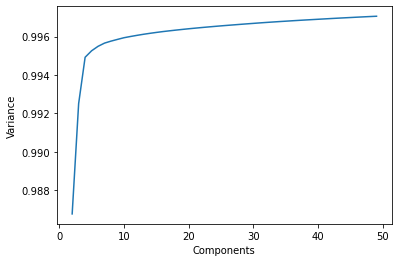

In [25]:
ax = sns.lineplot(data=res_df,x="Components",y="Variance")

In [26]:
pca = PCA(n_components=50)  # NOTE: This should be determined computationally!
crds = pca.fit_transform(fp_list) 

In [27]:
%time crds_embedded = TSNE(n_components=2, learning_rate="auto").fit_transform(crds)

/home/julius/miniconda3/envs/rxt/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


CPU times: user 5min 33s, sys: 4.98 s, total: 5min 38s
Wall time: 21.6 s


In [28]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['is_active'] = (data["pchembl_value"] > 6.5)

In [29]:
tsne_df.head()

,X,Y,is_active
0,86.138054,16.592957,False
1,-14.870776,-53.548248,False
2,-14.713140,-52.073059,True
3,-48.184967,1.074670,False
4,-62.748947,-11.331161,False


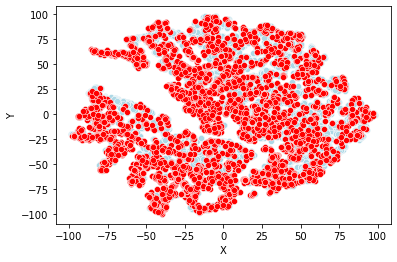

In [30]:
ax = sns.scatterplot(data=tsne_df.query("is_active == 0"),x="X",y="Y",color='lightblue')
ax = sns.scatterplot(data=tsne_df.query("is_active == 1"),x="X",y="Y",color='red')